# AOS_PS1_inspect 

In [1]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Show the raw and postISR LSSTComCam simulated data 

In [40]:
def plot_raw_postISR(repo_dir,instrument):
    
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded']
                             )


    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]
    zscale = ZScaleInterval()
     
    # initialize the figure 
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    # get the raw exposure 
    exposure = butler.get('raw', detector='R22_S21', instrument=instrument,
              exposure=exp_num,)

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[0].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[0].set_title("raw")
    ax[0].set_xlabel('x [px]')
    ax[0].set_ylabel('y [px]')

    # get the postISR exposure 
    exposure = butler.get('postISRCCD', detector='R22_S21', instrument=instrument,
              exposure=exp_num,collections=['run1'])

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[1].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[1].set_title("postISR")
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    fig.suptitle(f"{instrument} {exposure.getDetector().getName()}, no transpose",
                fontsize=18)


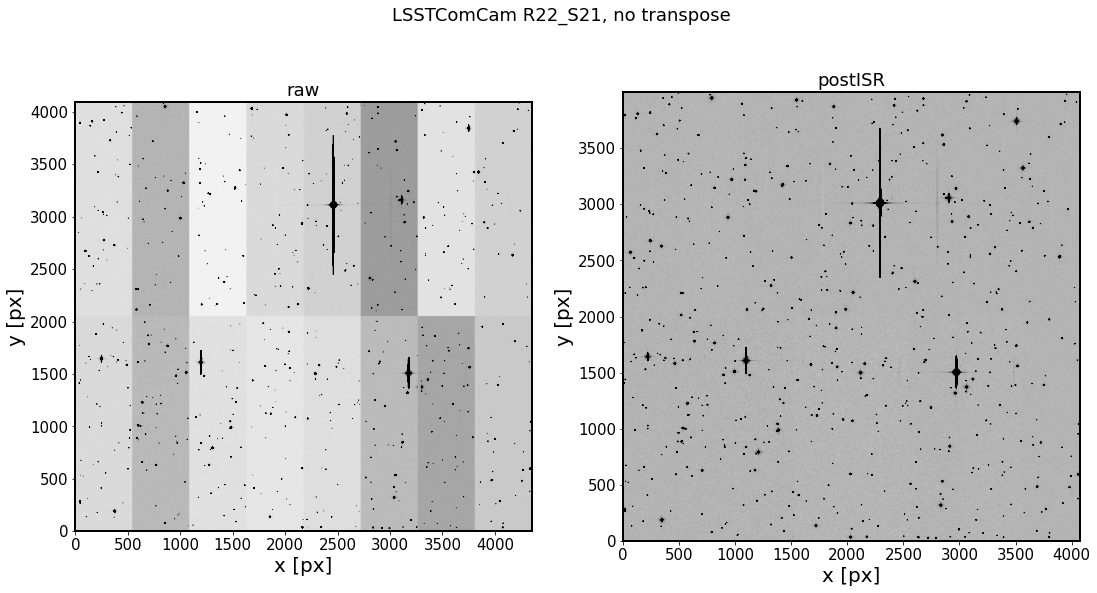

In [41]:
%matplotlib inline

instrument = 'LSSTComCam'
repo_dir = '/project/scichris/aos/ps1_phosim/comCam/med/focal/DATA/'
plot_raw_postISR(repo_dir,instrument)    
    

Do the same with the stack tools: 

### Show the letter F : do we have the same orientation? 

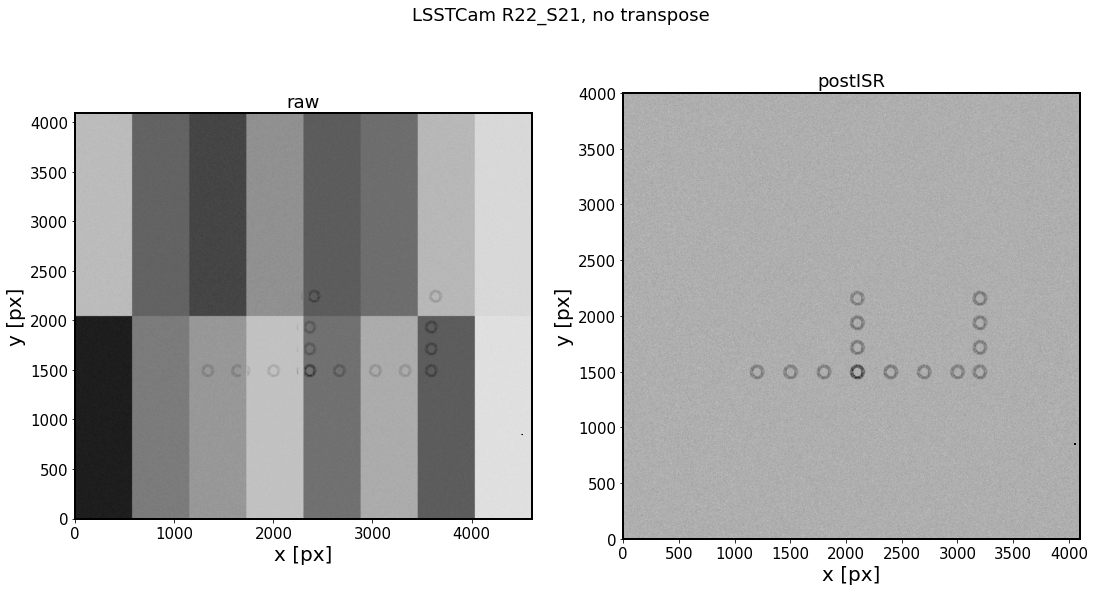

In [42]:
%matplotlib inline

instrument = 'LSSTCam'
repo_dir = '/project/scichris/aos/images/lsstCam/letter_R22/DATA/'
plot_raw_postISR(repo_dir,instrument)    
    

# Compare to WCS 

In [ ]:

cat = np.genfromtxt('stars_comCam_PS1_med_focal.inst', skip_header=16)

In [48]:
import numpy as np

import pandas as pd
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)
import lsst.geom

from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

Using /project/scichris/aos/ps1_phosim/comCam/med/focal/DATA


Text(0, 0.5, 'y [px]')

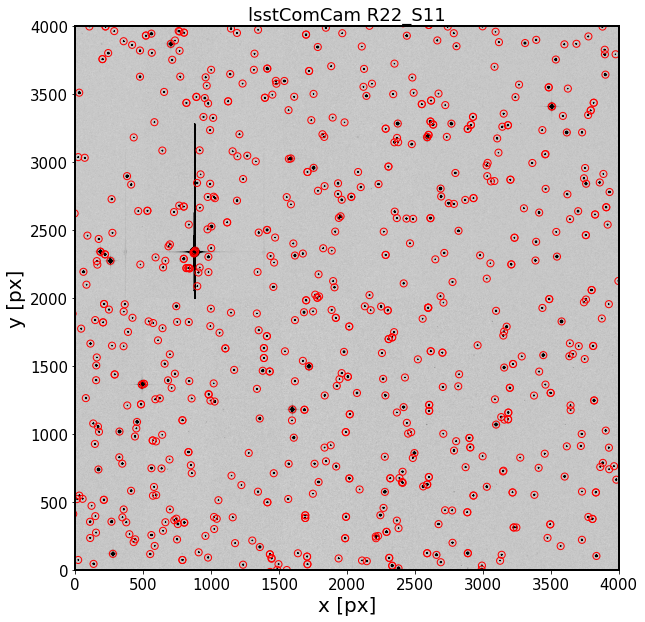

In [66]:
%matplotlib inline

root_dir = '/project/scichris/aos/ps1_phosim/comCam/med/focal/'
instrument = 'LSSTComCam'
repo_name = 'DATA'
repo_dir = os.path.join(root_dir,repo_name)

print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )
# this is just to get the exposure  number
# so that we don't have  to guess...
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )
exp_num = dataset.dataId["exposure"]

    
exposure = butler.get('postISRCCD', detector='R22_S11', instrument=instrument,
          exposure=exp_num,collections=['run1'])



# read in the input instance catalog 
cat = np.genfromtxt('/project/scichris/aos/ps1_phosim/stars_comCam_PS1_med_focal.inst',
                        skip_header=16)

cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])

wcs = exposure.getWcs()

x_pix_list = []
y_pix_list = []
for i in range(len(cat_df)):
    x_pix, y_pix = wcs.skyToPixel(
        lsst.geom.SpherePoint(
            cat_df.iloc[i]['ra'], cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    x_pix_list.append(x_pix)
    y_pix_list.append(y_pix)
    

# obtain the postISR metadata from the exposure 
postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG']


# get the WCS using the input ROTANG 
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (postIsr_md['ROTANG'])*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False)

# calculate the position given the x,y 
new_x_pix_list = []
new_y_pix_list = []

for i in range(len(cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            cat_df.iloc[i]['ra'], cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x_pix_list.append(x_pix)
    new_y_pix_list.append(y_pix)
    

# plot the WCS-inferred stellar position on top of the data 
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(data, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x_pix_list, new_y_pix_list,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.title(f"lsstComCam {exposure.getDetector().getName()}")
plt.xlabel('x [px]')
plt.ylabel('y [px]')


Text(0, 0.5, 'y [px]')

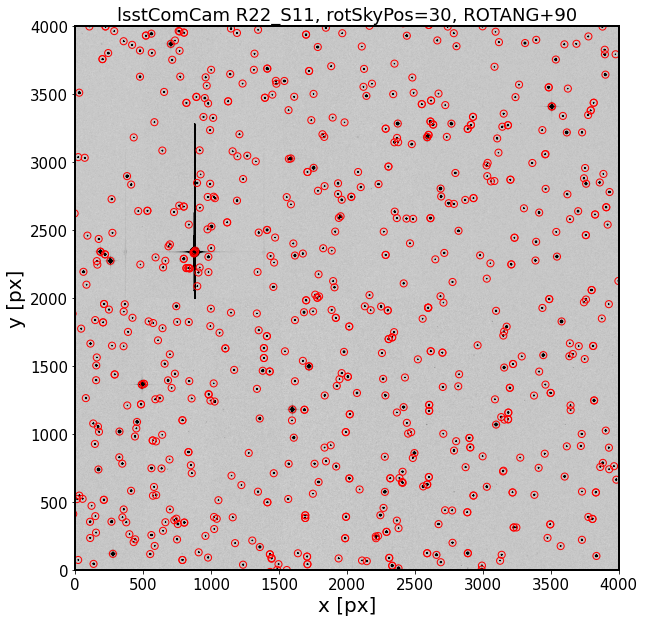